Authors: Antoine A. Ruzette
Date: 2025-02-21

This notebook processes cell measurement tables exported from QuPath to plot the spatial distribution of cell-level pixel intensity in relation to a modelled stromal border. It also supports the comparison of confusion matrices between threshold- and machine learning-based cell classification.

Contains the code to plot data from images containing four channels: DAPI (nuclei), TRITC (cytokeratin), FITC (fibronectin) and CY5 (Ki67). 

In [10]:
import os
import pandas as pd
import numpy as np
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import natsort
import re
from matplotlib.ticker import LogFormatterSciNotation
from fitter import Fitter, get_common_distributions, get_distributions

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

## Back-end functions

In [7]:
def load_and_preprocess_files(folder_path, file_paths, expected_columns):
    """
    Load and preprocess CSV files.

    Args:
        folder_path (str): Path to the folder containing CSV files.
        file_paths (list): List of file names.
        expected_columns (dict): Dictionary mapping expected column keys to possible names.

    Returns:
        list: A list of processed DataFrames (one per image).
        dict: Column mapping for use in plotting.
    """
    dfs = []
    final_column_mapping = {}

    for image in file_paths:
        print(f"\n🔹 Processing: {image}")
        file_path = os.path.join(folder_path, image)

        # Load CSV to check available columns first
        try:
            df_sample = pd.read_csv(file_path, nrows=1)
            available_columns = df_sample.columns.tolist()
            print(f"✅ Available Columns: {available_columns}")
        except Exception as e:
            print(f"❌ Error loading {image}: {e}")
            continue

        # Dynamically map expected column names to available ones
        column_mapping = {}
        for key, possible_names in expected_columns.items():
            for name in possible_names:
                if name in available_columns:
                    column_mapping[key] = name
                    break
            else:
                print(f"⚠️ Warning: {key} column not found in {image}. Skipping.")

        if not column_mapping:
            print(f"⚠️ Skipping {image} as no expected columns were found.")
            continue

        # Reload dataframe with only found columns
        try:
            df = pd.read_csv(file_path, usecols=list(column_mapping.values()))
        except Exception as e:
            print(f"❌ Error loading selected columns in {image}: {e}")
            continue

        # Skip this file if essential columns are missing
        essential_columns = ["DAPI", "Ki67_647"]
        missing_essential = [col for col in essential_columns if col not in column_mapping]
        if missing_essential:
            print(f"⚠️ Skipping {image} due to missing essential columns: {missing_essential}")
            continue

        # Remove outliers dynamically (only for present columns)
        outlier_limits = {}
        for key in ["DAPI", "Ki67_647", "KER_488", "FN_568"]:
            if key in column_mapping:
                col_name = column_mapping[key]
                p01 = df[col_name].quantile(0.01)
                p99 = df[col_name].quantile(0.99)
                outlier_limits[col_name] = (p01, p99)

        print(f"📊 Outlier Thresholds: {outlier_limits}")

        # Filter outliers
        df_no_outlier = df.copy()
        for col, (p01, p99) in outlier_limits.items():
            df_no_outlier = df_no_outlier[(df_no_outlier[col] >= p01) & (df_no_outlier[col] <= p99)]

        if df_no_outlier.empty:
            print(f"⚠️ Skipping {image} as it became empty after outlier removal.")
            continue

        # ✅ Store actual filename instead of "1G", "2G" etc.
        df_no_outlier["Image"] = os.path.splitext(os.path.basename(image))[0]

        dfs.append(df_no_outlier)

        # Save column mapping for later use
        final_column_mapping = column_mapping  

    if dfs:
        return dfs, final_column_mapping
    else:
        print("⚠️ No valid data loaded.")
        return [], {}


# Confusion matrix to compare ML vs threshold-based classification

## Check if datasets have same length

In [27]:
expected_columns = {
    "Object ID": ["Object ID"],
    "Class": ["Classification"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

file_paths = [
    "all_measurements.csv"
]

folder_thr = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/ML/20250301_ML_spatial_data_full"
folder_ML = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/thresholds/20250301_thresholds_spatial_data_full"

thr_label, _ = load_and_preprocess_files(folder_thr, file_paths, expected_columns)
ML_all, _ = load_and_preprocess_files(folder_ML, file_paths, expected_columns)


# Now safely perform set operations on 'Object ID'
common_object_ids = len(set(ML_all[0]['Object ID']).intersection(set(thr_label[0]['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all[0]['Object ID'])) == len(set(thr_label[0]['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup = {
    'FITC KER: CY5 Ki67': 'Ki67+: KER+',
    'FITC KER': 'Ki67-: KER+',
    'CY5 Ki67': 'Ki67+: KER-',
    # Add more mappings as needed
    np.nan: 'Ki67-: KER-'  # Represent NaN as a class itself
}


# Apply the lookup table to both datasets
# ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)
# thr_label[0]['Classification'] = thr_label[0]['Classification'].map(class_lookup)
ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)

# # Print class distributions to verify
print("Updated Thresholds dataset classifications:")
print(thr_label[0]['Classification'].value_counts())

print("\nUpdated ML dataset classifications:")
print(ML_all[0]['Classification'].value_counts())

thr_label = thr_label[0]
ML_all = ML_all[0]


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', '

Thresholds dataset classifications:
Classification
Ki67-: KER+    294433
Ki67+: KER+     87364
Ki67-: KER-     33707
Ki67+: KER-      5287
Name: count, dtype: int64

ML dataset classifications:
Classification
Ki67-: KER+    272544
Ki67+: KER+    148238
Ki67-: KER-         7
Ki67+: KER-         2
Name: count, dtype: int64
True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 52219
Predicted Class: Ki67+: KER-, Count: 5287
Predicted Class: Ki67-: KER-, Count: 3368

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 242206
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 30338

True Class: Ki67+: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 1
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 1

True Class: Ki67-: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 7
Predicted

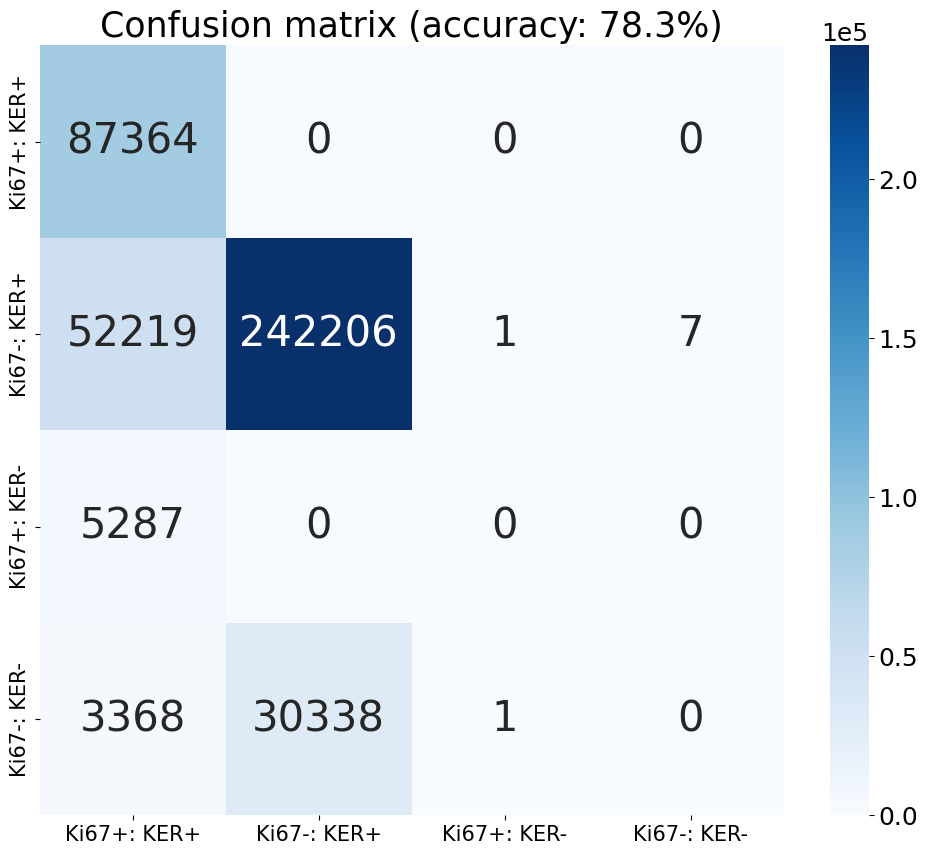

In [28]:
print("Thresholds dataset classifications:")
print(thr_label['Classification'].value_counts())

print("\nML dataset classifications:")
print(ML_all['Classification'].value_counts())

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67+: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+', 'Ki67+: KER-', 'Ki67-: KER-']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=25)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size
    
plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/supp_Ki67_confusion_matrix.png", dpi=300)
plt.show()

True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 52219

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 242206

Ratio of agreement between the two methods: 86.32254989012256


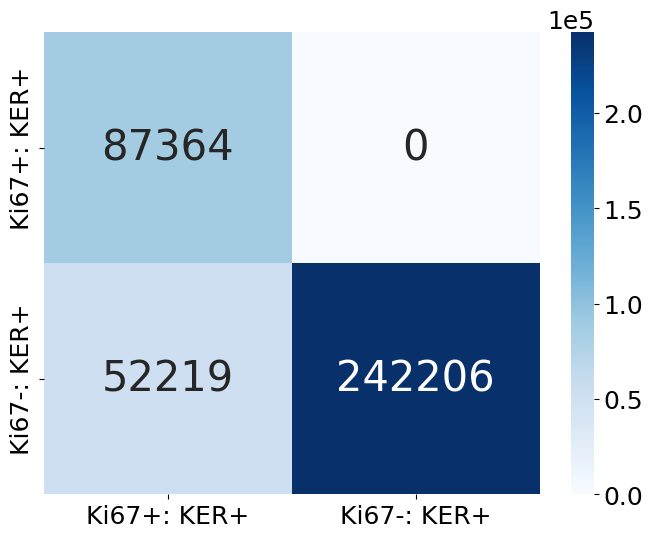

In [29]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
# plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/Ki67_confusion_matrix.png", dpi=300)
plt.show()

## Confusion matrix: image-specific threshold vs single reference threshold

### #1

### #6G reference

In [12]:
expected_columns = {
    "Object ID": ["Object ID"],
    "Class": ["Classification"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

file_paths = [
    "all_measurements.csv"
]

folder_thr = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/ML/20250301_ML_spatial_data_full"
folder_ML = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/single_threshold/20250310_single_threshold_#1_ref"

thr_label, _ = load_and_preprocess_files(folder_thr, file_paths, expected_columns)
ML_all, _ = load_and_preprocess_files(folder_ML, file_paths, expected_columns)


# Now safely perform set operations on 'Object ID'
common_object_ids = len(set(ML_all[0]['Object ID']).intersection(set(thr_label[0]['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all[0]['Object ID'])) == len(set(thr_label[0]['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup = {
    'FITC KER: CY5 Ki67': 'Ki67+: KER+',
    'FITC KER': 'Ki67-: KER+',
    'CY5 Ki67': 'Ki67+: KER-',
    # Add more mappings as needed
    np.nan: 'Ki67-: KER-'  # Represent NaN as a class itself
}


# Apply the lookup table to both datasets
# ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)
# thr_label[0]['Classification'] = thr_label[0]['Classification'].map(class_lookup)
ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)

# # Print class distributions to verify
print("Updated Thresholds dataset classifications:")
print(thr_label[0]['Classification'].value_counts())

print("\nUpdated ML dataset classifications:")
print(ML_all[0]['Classification'].value_counts())

thr_label = thr_label[0]
ML_all = ML_all[0]


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', '

Thresholds dataset classifications:
Classification
Ki67-: KER+    294433
Ki67+: KER+     87364
Ki67-: KER-     33707
Ki67+: KER-      5287
Name: count, dtype: int64

ML dataset classifications:
Classification
Ki67-: KER+    263977
Ki67+: KER+    156814
Name: count, dtype: int64
True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 60179
Predicted Class: Ki67+: KER-, Count: 5287
Predicted Class: Ki67-: KER-, Count: 3984

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 234254
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 29723

True Class: Ki67+: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 0

True Class: Ki67-: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Clas

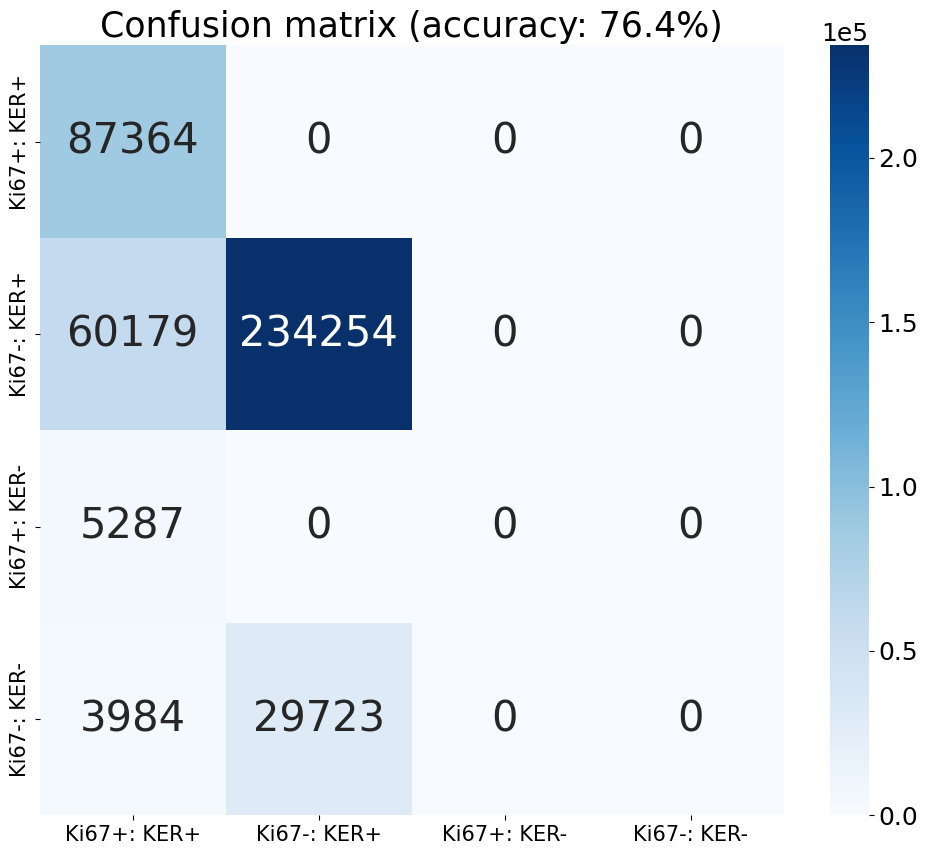

In [13]:
print("Thresholds dataset classifications:")
print(thr_label['Classification'].value_counts())

print("\nML dataset classifications:")
print(ML_all['Classification'].value_counts())

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67+: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+', 'Ki67+: KER-', 'Ki67-: KER-']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=25)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size
    
# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/supp_Ki67_confusion_matrix.png", dpi=300)
plt.show()

True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 60179

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 234254

Ratio of agreement between the two methods: 84.23795891533983


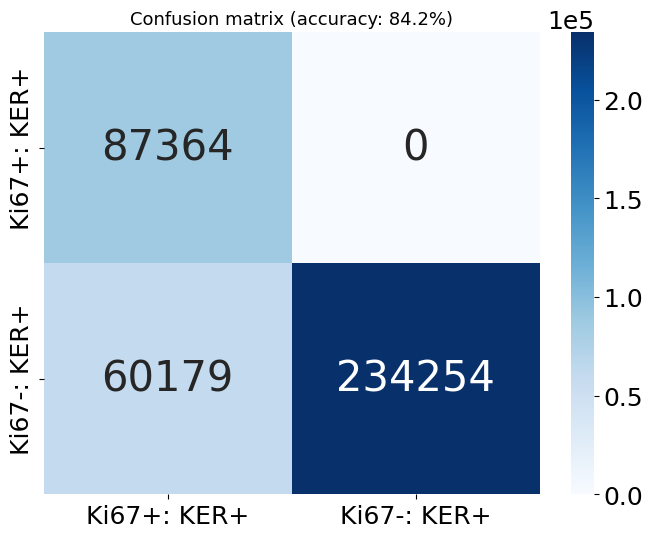

In [ ]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/Ki67_confusion_matrix.png", dpi=300)
plt.show()

### #2

In [19]:
expected_columns = {
    "Object ID": ["Object ID"],
    "Class": ["Classification"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

file_paths = [
    "all_measurements.csv"
]

folder_thr = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/ML/20250301_ML_spatial_data_full"
folder_ML = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/single_threshold/20250310_single_threshold_#2_ref"

thr_label, _ = load_and_preprocess_files(folder_thr, file_paths, expected_columns)
ML_all, _ = load_and_preprocess_files(folder_ML, file_paths, expected_columns)


# Now safely perform set operations on 'Object ID'
common_object_ids = len(set(ML_all[0]['Object ID']).intersection(set(thr_label[0]['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all[0]['Object ID'])) == len(set(thr_label[0]['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup = {
    'FITC KER: CY5 Ki67': 'Ki67+: KER+',
    'FITC KER': 'Ki67-: KER+',
    'CY5 Ki67': 'Ki67+: KER-',
    # Add more mappings as needed
    np.nan: 'Ki67-: KER-'  # Represent NaN as a class itself
}


# Apply the lookup table to both datasets
# ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)
# thr_label[0]['Classification'] = thr_label[0]['Classification'].map(class_lookup)
ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)

# # Print class distributions to verify
print("Updated Thresholds dataset classifications:")
print(thr_label[0]['Classification'].value_counts())

print("\nUpdated ML dataset classifications:")
print(ML_all[0]['Classification'].value_counts())

thr_label = thr_label[0]
ML_all = ML_all[0]


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', '

Thresholds dataset classifications:
Classification
Ki67-: KER+    294433
Ki67+: KER+     87364
Ki67-: KER-     33707
Ki67+: KER-      5287
Name: count, dtype: int64

ML dataset classifications:
Classification
Ki67-: KER+    261986
Ki67+: KER+    158805
Name: count, dtype: int64
True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 62068
Predicted Class: Ki67+: KER-, Count: 5287
Predicted Class: Ki67-: KER-, Count: 4086

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 232365
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 29621

True Class: Ki67+: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 0

True Class: Ki67-: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Clas

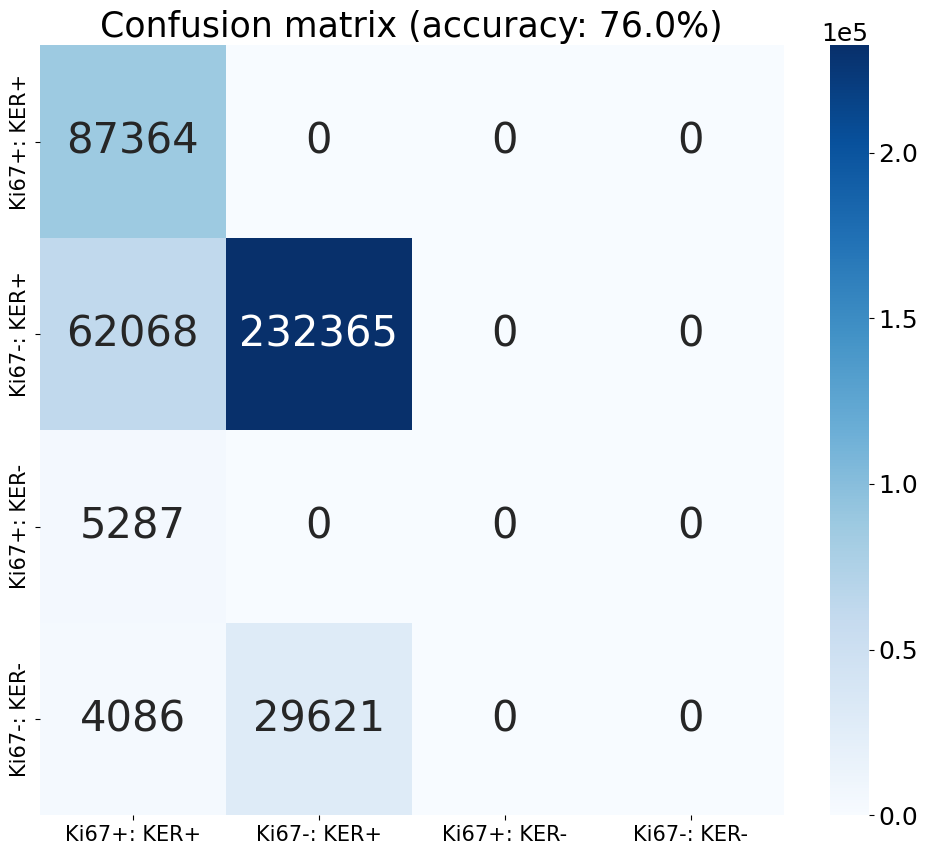

In [20]:
print("Thresholds dataset classifications:")
print(thr_label['Classification'].value_counts())

print("\nML dataset classifications:")
print(ML_all['Classification'].value_counts())

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67+: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+', 'Ki67+: KER-', 'Ki67-: KER-']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=25)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size
    
# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/supp_Ki67_confusion_matrix.png", dpi=300)
plt.show()

True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 62068

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 232365

Ratio of agreement between the two methods: 83.74319337239423


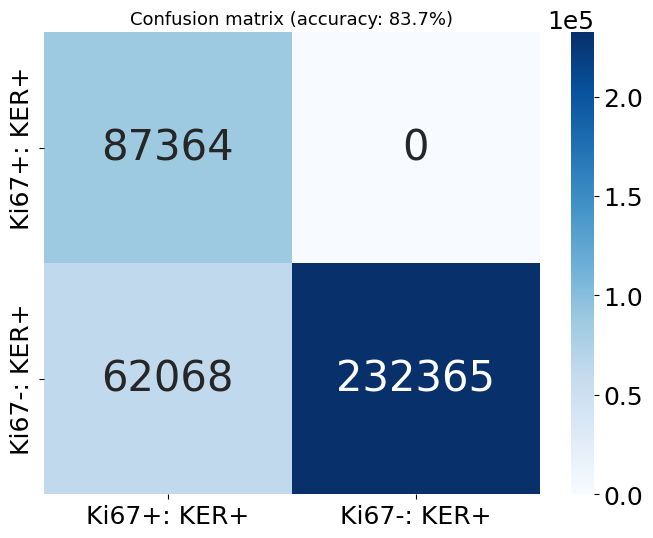

In [ ]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/Ki67_confusion_matrix.png", dpi=300)
plt.show()

### #3


In [23]:
expected_columns = {
    "Object ID": ["Object ID"],
    "Class": ["Classification"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

file_paths = [
    "all_measurements.csv"
]

folder_thr = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/ML/20250301_ML_spatial_data_full"
folder_ML = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/single_threshold/20250310_single_threshold_#3_ref"

thr_label, _ = load_and_preprocess_files(folder_thr, file_paths, expected_columns)
ML_all, _ = load_and_preprocess_files(folder_ML, file_paths, expected_columns)


# Now safely perform set operations on 'Object ID'
common_object_ids = len(set(ML_all[0]['Object ID']).intersection(set(thr_label[0]['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all[0]['Object ID'])) == len(set(thr_label[0]['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup = {
    'FITC KER: CY5 Ki67': 'Ki67+: KER+',
    'FITC KER': 'Ki67-: KER+',
    'CY5 Ki67': 'Ki67+: KER-',
    # Add more mappings as needed
    np.nan: 'Ki67-: KER-'  # Represent NaN as a class itself
}


# Apply the lookup table to both datasets
# ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)
# thr_label[0]['Classification'] = thr_label[0]['Classification'].map(class_lookup)
ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)

# # Print class distributions to verify
print("Updated Thresholds dataset classifications:")
print(thr_label[0]['Classification'].value_counts())

print("\nUpdated ML dataset classifications:")
print(ML_all[0]['Classification'].value_counts())

thr_label = thr_label[0]
ML_all = ML_all[0]


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', '

Thresholds dataset classifications:
Classification
Ki67-: KER+    294433
Ki67+: KER+     87364
Ki67-: KER-     33707
Ki67+: KER-      5287
Name: count, dtype: int64

ML dataset classifications:
Classification
Ki67-: KER+    296755
Ki67+: KER+    124036
Name: count, dtype: int64
True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 29549
Predicted Class: Ki67+: KER-, Count: 5287
Predicted Class: Ki67-: KER-, Count: 1836

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 264884
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 31871

True Class: Ki67+: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 0

True Class: Ki67-: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Clas

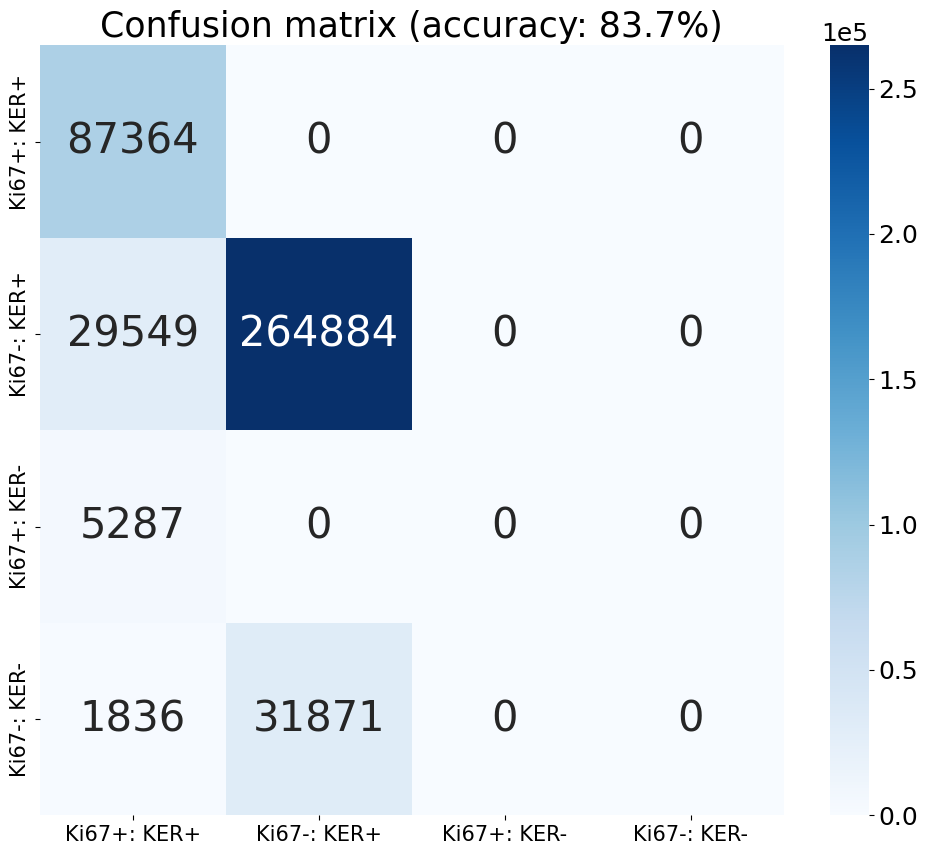

In [25]:
print("Thresholds dataset classifications:")
print(thr_label['Classification'].value_counts())

print("\nML dataset classifications:")
print(ML_all['Classification'].value_counts())

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67+: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+', 'Ki67+: KER-', 'Ki67-: KER-']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=25)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size
    
# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/supp_Ki67_confusion_matrix.png", dpi=300)
plt.show()

True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 29549

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 264884

Ratio of agreement between the two methods: 92.26054683509824


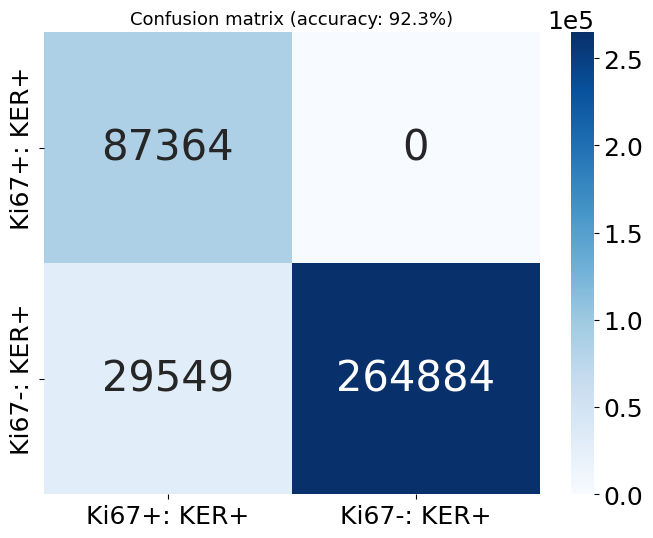

In [26]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/Ki67_confusion_matrix.png", dpi=300)
plt.show()

### #4

In [30]:
expected_columns = {
    "Object ID": ["Object ID"],
    "Class": ["Classification"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

file_paths = [
    "all_measurements.csv"
]

folder_thr = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/ML/20250301_ML_spatial_data_full"
folder_ML = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/single_threshold/20250310_single_threshold_#4_ref"

thr_label, _ = load_and_preprocess_files(folder_thr, file_paths, expected_columns)
ML_all, _ = load_and_preprocess_files(folder_ML, file_paths, expected_columns)


# Now safely perform set operations on 'Object ID'
common_object_ids = len(set(ML_all[0]['Object ID']).intersection(set(thr_label[0]['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all[0]['Object ID'])) == len(set(thr_label[0]['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup = {
    'FITC KER: CY5 Ki67': 'Ki67+: KER+',
    'FITC KER': 'Ki67-: KER+',
    'CY5 Ki67': 'Ki67+: KER-',
    # Add more mappings as needed
    np.nan: 'Ki67-: KER-'  # Represent NaN as a class itself
}

ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)

# # Print class distributions to verify
print("Updated Thresholds dataset classifications:")
print(thr_label[0]['Classification'].value_counts())

print("\nUpdated ML dataset classifications:")
print(ML_all[0]['Classification'].value_counts())

thr_label = thr_label[0]
ML_all = ML_all[0]


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', '

Thresholds dataset classifications:
Classification
Ki67-: KER+    294433
Ki67+: KER+     87364
Ki67-: KER-     33707
Ki67+: KER-      5287
Name: count, dtype: int64

ML dataset classifications:
Classification
Ki67+: KER+    229666
Ki67-: KER+    191125
Name: count, dtype: int64
True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 127431
Predicted Class: Ki67+: KER-, Count: 5287
Predicted Class: Ki67-: KER-, Count: 9584

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 167002
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 24123

True Class: Ki67+: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 0

True Class: Ki67-: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 0
Predicted Class: Ki67+: KER-, Count: 0
Predicted Cla

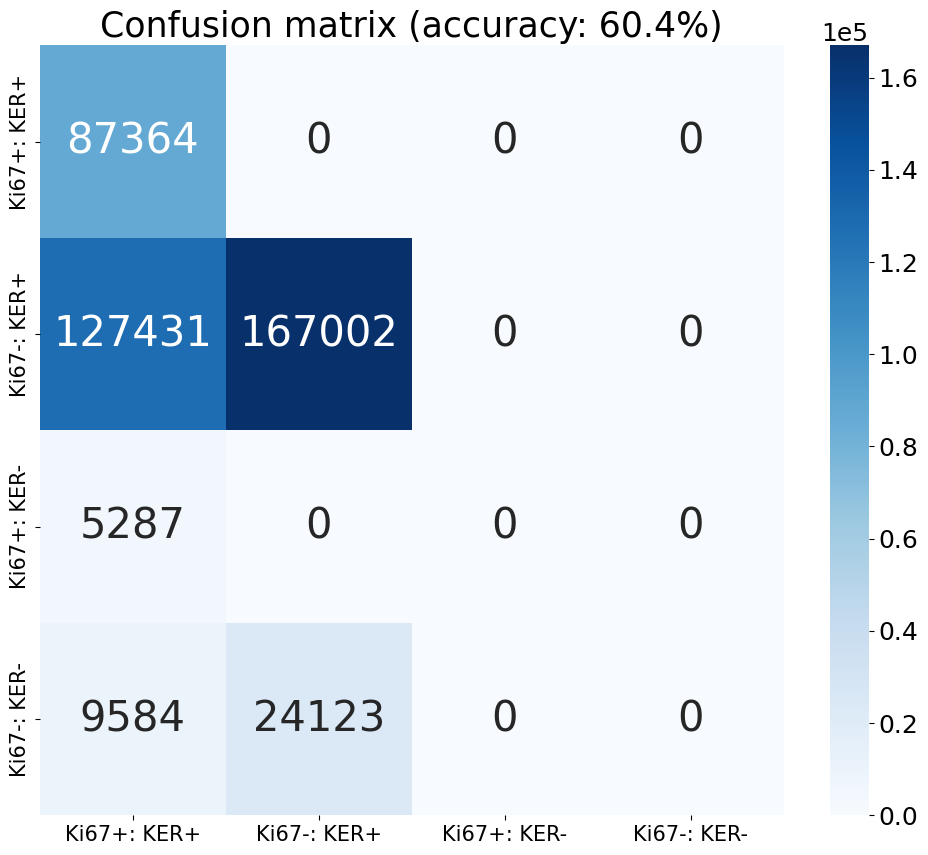

In [31]:
print("Thresholds dataset classifications:")
print(thr_label['Classification'].value_counts())

print("\nML dataset classifications:")
print(ML_all['Classification'].value_counts())

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67+: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+', 'Ki67+: KER-', 'Ki67-: KER-']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=25)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size
    
# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/supp_Ki67_confusion_matrix.png", dpi=300)
plt.show()

True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 87364
Predicted Class: Ki67-: KER+, Count: 127431

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 167002

Ratio of agreement between the two methods: 66.6233626770247


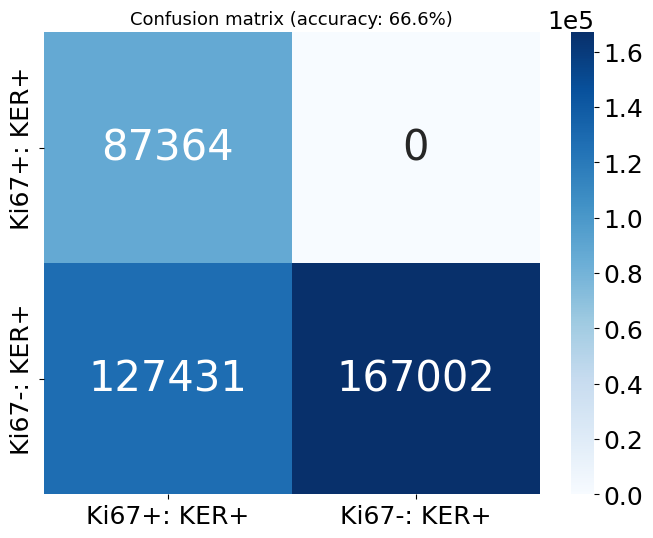

In [33]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/Ki67_confusion_matrix.png", dpi=300)
plt.show()

### #5

In [34]:
expected_columns = {
    "Object ID": ["Object ID"],
    "Class": ["Classification"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["FITC KER: Cytoplasm: Median"],
    "Ki67_647": ["CY5 Ki67: Nucleus: Max"],
    "FN_568": ["TRITC FN: Cell: Median"],
    "Nucleus_Area": ["Nucleus: Area µm^2"]
}

file_paths = [
    "all_measurements.csv"
]

folder_thr = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/ML/20250301_ML_spatial_data_full"
folder_ML = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/results/single_threshold/20250310_single_threshold_#5_ref"

thr_label, _ = load_and_preprocess_files(folder_thr, file_paths, expected_columns)
ML_all, _ = load_and_preprocess_files(folder_ML, file_paths, expected_columns)


# Now safely perform set operations on 'Object ID'
common_object_ids = len(set(ML_all[0]['Object ID']).intersection(set(thr_label[0]['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all[0]['Object ID'])) == len(set(thr_label[0]['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup = {
    'FITC KER: CY5 Ki67': 'Ki67+: KER+',
    'FITC KER': 'Ki67-: KER+',
    'CY5 Ki67': 'Ki67+: KER-',
    # Add more mappings as needed
    np.nan: 'Ki67-: KER-'  # Represent NaN as a class itself
}


# Apply the lookup table to both datasets
# ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)
# thr_label[0]['Classification'] = thr_label[0]['Classification'].map(class_lookup)
ML_all[0]['Classification'] = ML_all[0]['Classification'].map(class_lookup)

# # Print class distributions to verify
print("Updated Thresholds dataset classifications:")
print(thr_label[0]['Classification'].value_counts())

print("\nUpdated ML dataset classifications:")
print(ML_all[0]['Classification'].value_counts())

thr_label = thr_label[0]
ML_all = ML_all[0]


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'FITC KER: Nucleus: Mean', '

Thresholds dataset classifications:
Classification
Ki67-: KER+    294433
Ki67+: KER+     87364
Ki67-: KER-     33707
Ki67+: KER-      5287
Name: count, dtype: int64

ML dataset classifications:
Classification
Ki67-: KER+    279916
Ki67+: KER+    130269
Ki67-: KER-      9254
Ki67+: KER-      1352
Name: count, dtype: int64
True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 86695
Predicted Class: Ki67-: KER+, Count: 36300
Predicted Class: Ki67+: KER-, Count: 5064
Predicted Class: Ki67-: KER-, Count: 2210

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 253392
Predicted Class: Ki67+: KER-, Count: 0
Predicted Class: Ki67-: KER-, Count: 26524

True Class: Ki67+: KER-
Predicted Class: Ki67+: KER+, Count: 669
Predicted Class: Ki67-: KER+, Count: 334
Predicted Class: Ki67+: KER-, Count: 223
Predicted Class: Ki67-: KER-, Count: 126

True Class: Ki67-: KER-
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 440

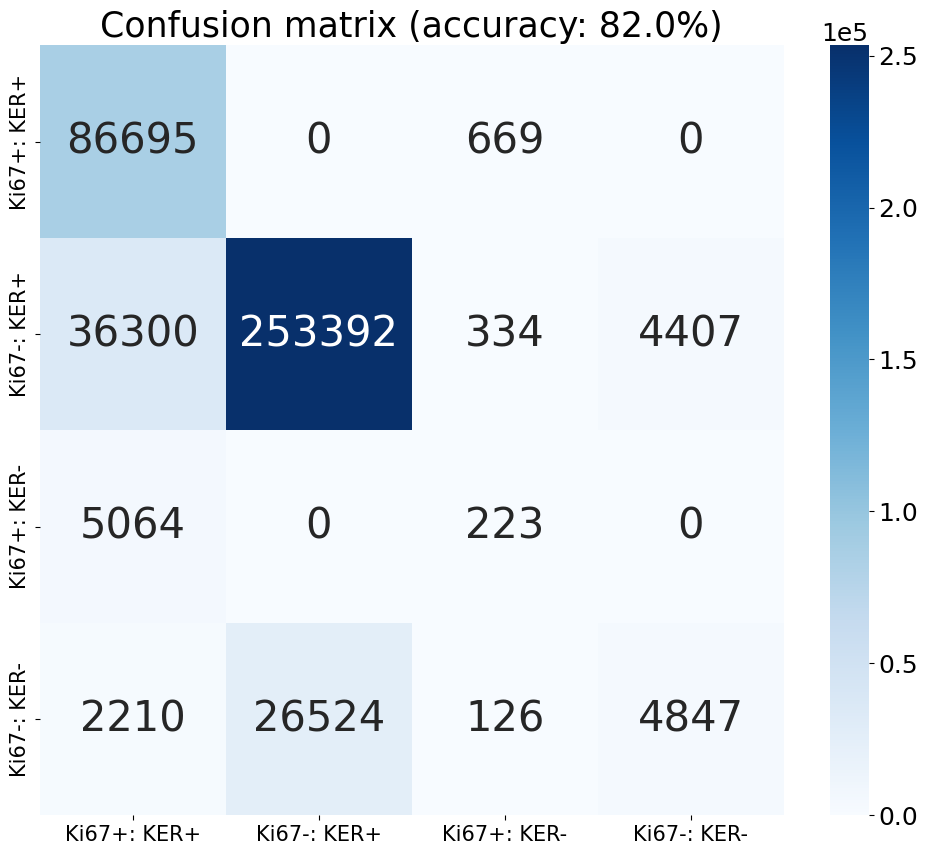

In [35]:
print("Thresholds dataset classifications:")
print(thr_label['Classification'].value_counts())

print("\nML dataset classifications:")
print(ML_all['Classification'].value_counts())

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67+: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0},
    'Ki67-: KER-': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0, 'Ki67+: KER-': 0, 'Ki67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+', 'Ki67+: KER-', 'Ki67-: KER-']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=25)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size
    
# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/supp_Ki67_confusion_matrix.png", dpi=300)
plt.show()

True Class: Ki67+: KER+
Predicted Class: Ki67+: KER+, Count: 86695
Predicted Class: Ki67-: KER+, Count: 36300

True Class: Ki67-: KER+
Predicted Class: Ki67+: KER+, Count: 0
Predicted Class: Ki67-: KER+, Count: 253392

Ratio of agreement between the two methods: 90.35567115761171


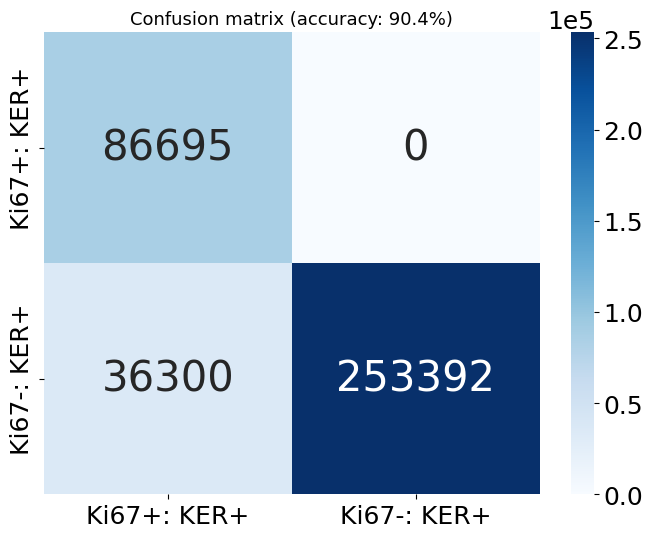

In [36]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['Ki67+: KER+', 'Ki67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'Ki67+: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
    'Ki67-: KER+': {'Ki67+: KER+': 0, 'Ki67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['Ki67+: KER+', 'Ki67-: KER+']
#classes = ['KER+: Ki67+', 'KER+: Ki67-', 'KER-: Ki67+', 'KER-: Ki67-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 30})
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
# plt.ylabel('Threshold-based classification', fontsize=18)
# plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick labels font size

# Increase font size of the exponent (scientific notation) above the colorbar
if cbar.ax.yaxis.get_offset_text():  # Check if offset text exists
    cbar.ax.yaxis.get_offset_text().set_size(18)  # Set its font size

# plt.savefig("/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_Ki67/plots/Ki67_confusion_matrix.png", dpi=300)
plt.show()